# ОБЗОР ТРЕХ МОДЕЛЕЙ МАШИННОГО ОБУЧЕНИЯ ДЛЯ РЕКОМЕНДАТЕЛЬНОЙ СИСТЕМЫ

## Описание проекта
Оператор мобильной связи «Мегалайн» выяснил: многие клиенты пользуются архивными тарифами. Они хотят построить систему, способную проанализировать поведение клиентов и предложить пользователям новый тариф: «Смарт» или «Ультра».
В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы. Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц.

Описание данных:
- сalls — количество звонков,
- minutes — суммарная длительность звонков в минутах,
- messages — количество sms-сообщений,
- mb_used — израсходованный интернет-трафик в Мб,
- is_ultra — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

### Постановка задачи



Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Постройте модель с максимальным значением accuracy. <b>Важно:</b> минимальное допустимое значение accuracy = 0.75. 

### План исследования
Шаг 1. Откройте файл с данными и изучите его.  
Шаг 2. Разделите исходные данные на обучающую, валидационную и тестовую выборки.  
Шаг 3. Исследуйте качество разных моделей, меняя гиперпараметры. Кратко напишите выводы исследования.  
Шаг 4. Проверьте качество модели на тестовой выборке.  
Шаг 5. Проверьте модели на вменяемость.  
Шаг 6. Сделайте общий вывод.

In [1]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
#Фиксируем значение random_state
seed = 761374

## Обзор данных
Поместим данные в `DataFrame` и посмотрим на общую информацию.

In [2]:
df = pd.read_csv('/datasets/users_behavior.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


Пропусков нет, типы данных определились корректно.  
Проверим наличие дубликатов.

In [3]:
df.duplicated().sum()

0

Дубликаты не обнаружены.  
На примере нескольких строк оценим датасет визульно.

In [4]:
df.head(10)

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0
5,58.0,344.56,21.0,15823.37,0
6,57.0,431.64,20.0,3738.90,1
7,15.0,132.40,6.0,21911.60,0
8,7.0,43.39,3.0,2538.67,1
9,90.0,665.41,38.0,17358.61,0


Похоже, с данными все в порядке, предобработка не требуется.
## Формирование выборок
Поделим датасет на обучающую, валидационную и тестовую выборки в соотношении 3:1:1 (60%:20%:20%) соответственно. В качестве целевого признака используем столбец `is_ultra`.

In [5]:
tgt = df['is_ultra']
fts = df.loc[:, :'mb_used']
#Отделяем 60% под обучающую выборку, 40% под валидациюонную и тестовую
fts_train, fts_tmp, tgt_train, tgt_tmp = train_test_split(fts, tgt, test_size=0.4, random_state=seed)
#40% делим пополам: выделяем 20% под валидационную и 20% под тестовую выборку
fts_valid, fts_test, tgt_valid, tgt_test = train_test_split(fts_tmp, tgt_tmp, test_size=0.5, random_state=seed)

Проверим, как поделился датасет.

In [6]:
print('Признаки. Размер выборок: \n - обучающая:', fts_train.shape,
      '\n - валидационная:', fts_valid.shape,
      '\n - тестовая', fts_test.shape)
print('Целевой признак. Размер выборок: \n - обучающая:', tgt_train.shape,
      '\n - валидационная:', tgt_valid.shape,
      '\n - тестовая', tgt_test.shape)

Признаки. Размер выборок: 
 - обучающая: (1928, 4) 
 - валидационная: (643, 4) 
 - тестовая (643, 4)
Целевой признак. Размер выборок: 
 - обучающая: (1928,) 
 - валидационная: (643,) 
 - тестовая (643,)


Деление на выборки прошло корректно.
## Обучение, валидация и исследование моделей
В нашем случае целевой признак (тариф "Ультра" или "Смарт") является категориальным. Т.о., перед нами стоит задача классификации. Для ее решения воспользуемся алгоритмами `DecisionTreeClassifier`, `RandomForestClassifier` и `LogisticRegression`. 

Сформулируем план исследования:
 - определить модель;
 - определить наборы гиперпараметров; 
 - для каждого набора гиперперемтров:
     - обучить модель на обучающей выборке;
     - определить точность (`accuracy`) модели на валидационной выборке;
     - записать текущие гиперпараметры и точность в таблицу статистики;
 - найти модель с максимальной точностью;
 - проанализировать таблицу статистики.

Опишем функции, которые помогут нам в дальнешем исследовании.

In [7]:
def expand_params(index, p_collapsed_dict, p_expanded_list, p_expanded):
    """Формирует список словарей с различными комбинациями 
    гиперпараметров для инициализации модели.    
    АРГУМЕНТЫ:
    index -- адрес текущего параметра в словаре p_collapsed_dict 
    p_collapsed_dict -- словарь с параметрами вида 
                        {ИМЯ1 : [ЗНАЧЕНИЕ1, ...], ..., ИМЯn : [ЗНАЧЕНИЕn, ...]} 
    p_expanded_list -- список словарей с комбинациями параметров вида
                       [{ИМЯ1 : ЗНАЧЕНИЕ1, ..., ИМЯn : ЗНАЧЕНИЕn}, ...]
    p_expanded -- словарь для хранения текущей комбинации параметров 
    """    
    #Определяем количество параметров
    p_count = len(p_collapsed_dict)
    #Определяем текущий параметр
    p_name = list(p_collapsed_dict.keys())[index]
    #Определяем значения текущего параметр
    p_values = p_collapsed_dict[p_name]
    #Итерируем значения
    for p_value in p_values:                
        p_expanded[p_name] = p_value
        #Если список параметров не пройден до конца, проводим рекурсивный вызов
        if index+1 < p_count:
            expand_params(index+1, p_collapsed_dict, p_expanded_list, p_expanded)
        ##Если список параметров пройден до конца, сохраняем текущую комбинацию значений
        else:            
            p_expanded_list.append(p_expanded.copy())

Проверим работу функции на примере гиперпараметров для `RandomForestClassifier`.

In [8]:
hp_collapsed = {'n_estimators' : list(range(10, 31, 10)), 
                'max_depth' : list(range(1, 6)), 
                'random_state' : [seed]}
hp_expanded = []
expand_params(0, hp_collapsed, hp_expanded, {})
hp_expanded

[{'n_estimators': 10, 'max_depth': 1, 'random_state': 761374},
 {'n_estimators': 10, 'max_depth': 2, 'random_state': 761374},
 {'n_estimators': 10, 'max_depth': 3, 'random_state': 761374},
 {'n_estimators': 10, 'max_depth': 4, 'random_state': 761374},
 {'n_estimators': 10, 'max_depth': 5, 'random_state': 761374},
 {'n_estimators': 20, 'max_depth': 1, 'random_state': 761374},
 {'n_estimators': 20, 'max_depth': 2, 'random_state': 761374},
 {'n_estimators': 20, 'max_depth': 3, 'random_state': 761374},
 {'n_estimators': 20, 'max_depth': 4, 'random_state': 761374},
 {'n_estimators': 20, 'max_depth': 5, 'random_state': 761374},
 {'n_estimators': 30, 'max_depth': 1, 'random_state': 761374},
 {'n_estimators': 30, 'max_depth': 2, 'random_state': 761374},
 {'n_estimators': 30, 'max_depth': 3, 'random_state': 761374},
 {'n_estimators': 30, 'max_depth': 4, 'random_state': 761374},
 {'n_estimators': 30, 'max_depth': 5, 'random_state': 761374}]

In [9]:
def accuracy_check(m_type, h_params_list, fts_train, tgt_train, fts_valid, tgt_valid):
    """Для каждого набора гиперпараметров из списка h_params_list:
     - инициализирует модель m_type;
     - обучает модель на тренировочной выборке fts_train, tgt_train
     - определяет точность модели на валидационной выборке fts_valid, tgt_valid
     - записывает гиперпараметры и точность модели в DataFrame 
    Выводит на экран лучшую точность и соответствующие гиперпараметры.
    Возвращает модель с лучшей точностью, DataFrame со статистикой точности моделей.       
    АРГУМЕНТЫ:
    m_type -- тип модели (DecisionTreeClassifier, RandomForestClassifier, LogisticRegression)
    h_params_list -- список словарей с различными значениями гиперпараметов
    fts_train -- признаки обучающей выборки
    tgt_train -- целевой признак обучающей выборки
    fts_valid -- признаки валидационной выборки
    tgt_valid -- целевой признак валидационной выборки    
    """  
    #Текущая модель
    m = None
    #Лучшая модель
    m_best = None
    #Лучшая accuracy
    acc_best = 0
    #Лучшие гиперпараметры
    h_params_best = None
    #Датасет статистики
    stats = None    
    #Для каждого набора гиперпараметров
    for h_params in h_params_list:
        #Инициализируем модель
        if m_type == 'DecisionTreeClassifier':
            m = DecisionTreeClassifier(**h_params)        
        elif m_type == 'RandomForestClassifier':
            m = RandomForestClassifier(**h_params)
        elif m_type == 'LogisticRegression':
            m = LogisticRegression(**h_params)  
        elif m_type == 'DummyClassifier':
            m = DummyClassifier(**h_params)            
        #Обучаем модель
        m.fit(fts_train, tgt_train)
        #Считаем accuracy модели на валидационной выборке
        acc = accuracy_score(tgt_valid, m.predict(fts_valid))
        #Записываем лучшие значения
        if acc > acc_best:
            acc_best = acc
            m_best = m
            h_params_best = h_params
        #Заполняем датасет статистики
        stats_row = h_params.copy()
        stats_row['accuracy'] = acc         
        if stats is None:
            stats = pd.DataFrame(stats_row, index=[0])
        else:
            stats = stats.append(stats_row, ignore_index=True)                   
    #Выводим на экран информацию о лучшей модели
    print('Модель:', m_type, 
          '\n - лучшая точность', acc_best,
          '\n - лучшие параметры', h_params_best)
    #Возвращаем лучшую модель и датасет со статистикой
    return m_best, stats

### DecisionTreeClassifier
Для решающего дерева проварьируем значение глубины `max_depth`.

In [10]:
dtc_hp_col = {'max_depth' : list(range(1, 21)), 
              'random_state' : [seed]}

dtc_hp_exp = []
expand_params(0, dtc_hp_col, dtc_hp_exp, {}) 
dtc_best, dtc_stats = accuracy_check('DecisionTreeClassifier', 
                                    dtc_hp_exp, 
                                     fts_train, tgt_train, 
                                     fts_valid, tgt_valid)

Модель: DecisionTreeClassifier 
 - лучшая точность 0.7869362363919129 
 - лучшие параметры {'max_depth': 9, 'random_state': 761374}


Посмотрим на точность моделей с разными `max_depth`. 

[]

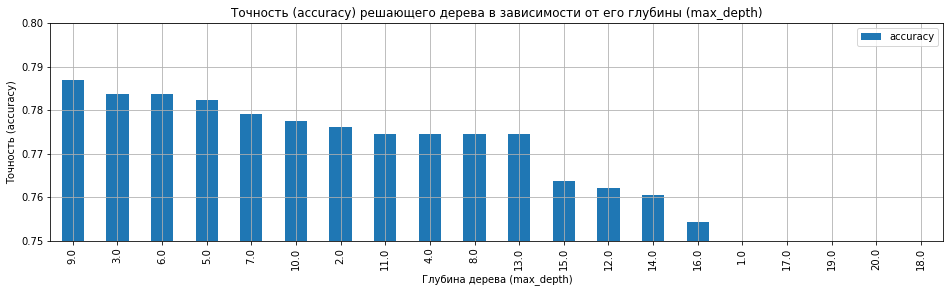

In [11]:
axes = dtc_stats.sort_values(by='accuracy', ascending=False)\
                .plot(kind='bar', 
                      grid=True, 
                      figsize=(16, 4),
                      x='max_depth', 
                      y='accuracy', 
                      ylim=(0.75, 0.8),
                      xlabel='Глубина дерева (max_depth)',
                      ylabel='Точность (accuracy)',
                      title='Точность (accuracy) решающего дерева в зависимости от его глубины (max_depth)')
axes.plot()

Максимальную точность `accuracy = 0.7869` показывает модель с глубиной `max_depth = 9`. Помимо нее в пятерку лучших в порядке убывания точности вошли модели с `max_depth = 3, 6, 5, 7`. Модели с `max_depth = 1, 17, 19, 20, 18` не преодолели порогового значения точности `accuracy = 0.7500`.

Любопытно, что зависимость между глубиной дерева и его предсказательной способностью не очевидна. 
### RandomForestClassifier
Для модели случайного леса варьируем количество деревьев `n_estimators` и их глубину `max_depth`. На основании статистики из предыдущего пункта уменьшим количество значений `max_depth`, установим его в промежутке от 3 до 9. Т.о., снизим ресурсоемкость нашего леса. 

In [12]:
rfc_hp_col = {'n_estimators' : list(range(10, 201, 10)),
              'max_depth' : list(range(3, 10)),
              'random_state' : [seed]}
rfc_hp_exp = []
expand_params(0, rfc_hp_col, rfc_hp_exp, {}) 
rfc_best, rfc_stats = accuracy_check('RandomForestClassifier', 
                                     rfc_hp_exp, 
                                     fts_train, tgt_train, 
                                     fts_valid, tgt_valid)

Модель: RandomForestClassifier 
 - лучшая точность 0.807153965785381 
 - лучшие параметры {'n_estimators': 110, 'max_depth': 9, 'random_state': 761374}


Посмотрим, как менялась `accuracy` моделей в зависимости от `n_estimators` и `max_depth`.

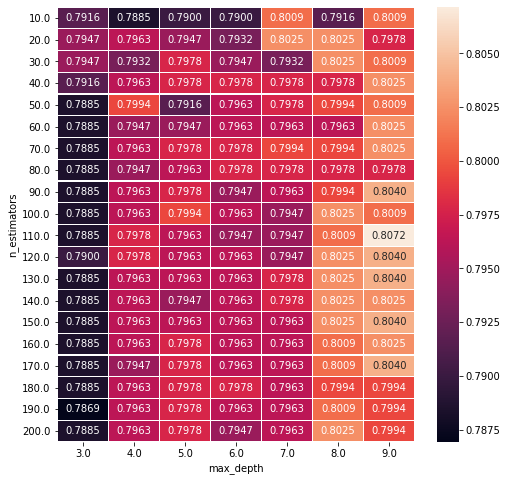

In [13]:
fig, axes = plt.subplots(figsize=(8, 8))
data = rfc_stats.pivot('n_estimators', 'max_depth', 'accuracy')
sns.heatmap(data, 
            ax=axes, 
            annot=True, 
            fmt=".4f", 
            linewidths=.25)
fig.show()

Максимальную точность `accuracy = 0.8072` показывает модель с `n_estimators = 110` и `max_depth = 9`. Все модели преодолели пороговое значение `accuracy = 0.7500`. Наиболее высокие результаты наблюдаем на всем диапазоне `n_estimators` при `max_depth = 8, 9`.
### LogisticRegression
Для модели логистической регрессии варьируем параметр `solver`. 

In [14]:
logr_hp_col = {'solver' : ['lbfgs', 'liblinear', 'newton-cg', 'sag', 'saga'],
               'random_state' : [seed]}
logr_hp_exp = []
expand_params(0, logr_hp_col, logr_hp_exp, {}) 
logr_best, logr_stats = accuracy_check('LogisticRegression', 
                                     logr_hp_exp, 
                                     fts_train, tgt_train, 
                                     fts_valid, tgt_valid)

Модель: LogisticRegression 
 - лучшая точность 0.7433903576982893 
 - лучшие параметры {'solver': 'lbfgs', 'random_state': 761374}


/opt/conda/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:456: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:305: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:456: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:305: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:456: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorith

Посмотрим на точность моделей с разными `solver`. 

[]

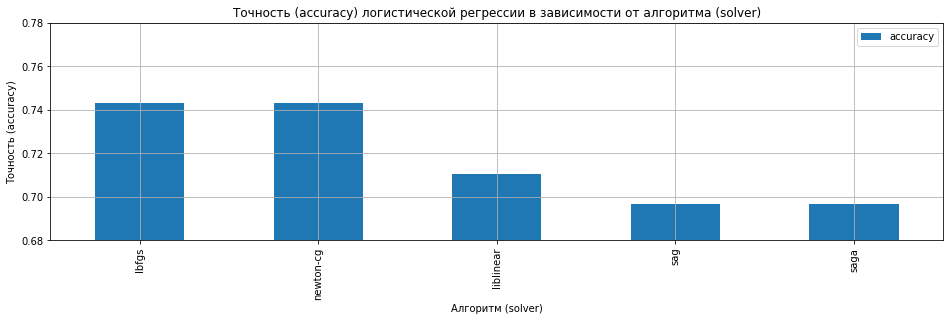

In [15]:
axes = logr_stats.sort_values(by='accuracy', ascending=False)\
                 .plot(kind='bar',
                       grid=True,
                       figsize=(16, 4),
                       x='solver',
                       y='accuracy',
                       ylim=(0.68, 0.78),
                       xlabel='Алгоритм (solver)',
                       ylabel='Точность (accuracy)',
                       title='Точность (accuracy) логистической регрессии в зависимости от алгоритма (solver)')
axes.plot()

In [16]:
logr_stats.sort_values(by='accuracy', ascending=False)

,solver,random_state,accuracy
0,lbfgs,761374,0.743390
2,newton-cg,761374,0.743390
1,liblinear,761374,0.710731
3,sag,761374,0.696734
4,saga,761374,0.696734


Ни одна модель не преодолела пороговое значение `accuracy = 0.7500`. Максимальную точность `accuracy = 0.7434` показывают модели с `solver = lbfgs, newton-cg`.
## Проверка моделей на тестовой выборке
Автоматизируем и проведем проверку с помощью функции. 

In [17]:
def compare_models_acc(fts_valid, tgt_valid, fts_test, tgt_test, models):
    """Выводит на экран точность моделей
    на валидационной и тестовой выборке.
    АРГУМЕНТЫ:
    fts_valid -- обекты валидационной выборки,
    tgt_valid -- целевой признак валидационной выборки,
    fts_test -- обекты тестовой выборки,
    tgt_test -- целевой признак тестовой выборки,
    models -- словарь вида {ТИП МОДЕЛИ : ЭКЗЕМПЛЯР МОДЕЛИ}
    """
    for m_name in models:        
        m = models[m_name]
        acc_valid = accuracy_score(tgt_valid, m.predict(fts_valid))
        acc_test = accuracy_score(tgt_test, m.predict(fts_test))
        print('Модель', m_name,
              '\n - точность на валидационной выборке:', acc_valid,
              '\n - точность на тестовой выборке     :', acc_test,
              '\n - разность тестовая - валидационная:', acc_test-acc_valid)

In [18]:
models_best = {'DecisionTreeClassifier' : dtc_best, 
               'RandomForestClassifier' : rfc_best, 
               'LogisticRegression' : logr_best}
compare_models_acc(fts_valid, tgt_valid, fts_test, tgt_test, models_best)

Модель DecisionTreeClassifier 
 - точность на валидационной выборке: 0.7869362363919129 
 - точность на тестовой выборке     : 0.7962674961119751 
 - разность тестовая - валидационная: 0.009331259720062213
Модель RandomForestClassifier 
 - точность на валидационной выборке: 0.807153965785381 
 - точность на тестовой выборке     : 0.8180404354587869 
 - разность тестовая - валидационная: 0.010886469673405896
Модель LogisticRegression 
 - точность на валидационной выборке: 0.7433903576982893 
 - точность на тестовой выборке     : 0.7387247278382582 
 - разность тестовая - валидационная: -0.004665629860031162


Все модели показывают практически одинаковый результат на обоих выборках, что является хорошим признаком. При этом DecisionTreeClassifier и RandomForestClassifier на ~0.010 точнее, а LogisticRegression на ~0.005 менее точна на тестовой выборке.
## Проверка моделей на адекватность
Для проверки воспользуемся моделью-болванкой DummyClassifier. Она игнорирует входные признаки объектов и не выстраивает связь между ними и целевым признаком. Вместо этого, модель использует исключительно значения выходного признака, и на основе гиперпараметра `strategy` выдает предсказание. Используем для `strategy` значения `most_frequent` и `uniform`, как наиболее  подходящие нашей задаче. 

In [19]:
dc_hp_col = {'strategy' : ['most_frequent', 'uniform'],
               'random_state' : [seed]}
dc_hp_exp = []
expand_params(0, dc_hp_col, dc_hp_exp, {}) 
dc_best, dc_stats = accuracy_check('DummyClassifier', 
                                     dc_hp_exp, 
                                     fts_train, tgt_train, 
                                     fts_valid, tgt_valid)

Модель: DummyClassifier 
 - лучшая точность 0.6967340590979783 
 - лучшие параметры {'strategy': 'most_frequent', 'random_state': 761374}


DummyClassifier не преодолел минимально допустимого значения `accuracy = 0.7500`. Проверим модель со `strategy = most_frequent` на тестовой выборке.

In [20]:
compare_models_acc(fts_valid, tgt_valid, 
                   fts_test, tgt_test, 
                   {'DummyClassifier' : dc_best})

Модель DummyClassifier 
 - точность на валидационной выборке: 0.6967340590979783 
 - точность на тестовой выборке     : 0.6889580093312597 
 - разность тестовая - валидационная: -0.007776049766718529


DummyClassifier показывает на ~0.05-0.12 более низкую предсказательную способность по сравнению с остальными рассмотренными моделями, что говорит в пользу их адекватности.
## Выводы
### Обзор данных
В ходе обзора было показано, что данные не нуждаются в предобработке ([см.2](#%D0%9E%D0%B1%D0%B7%D0%BE%D1%80-%D0%B4%D0%B0%D0%BD%D0%BD%D1%8B%D1%85)) 

### Формирование выборок
Исходные данные были разбиты на обучающую, валидационную и тестовую выборки в соотношении 60%+20%+20% соответственно ([см.3](#%D0%A4%D0%BE%D1%80%D0%BC%D0%B8%D1%80%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5-%D0%B2%D1%8B%D0%B1%D0%BE%D1%80%D0%BE%D0%BA))

### Исследование моделей
В ходе исследования было показано следующее: 
- модель DecisionTreeClassifier имеет максимальную `accuracy = 0.7869` с параметрами `max_depth = 9` ([см.4.1](#DecisionTreeClassifier)),
- модель RandomForestClassifier имеет максимальную `accuracy = 0.8072` c параметрами `n_estimators = 110`, `max_depth = 9` ([см.4.2](#RandomForestClassifier)),
- модель LogisticRegression не преодолевает порогового значения `accuracy = 0.7500` и показывает максимальную `accuracy = 0.7434` при `solver = lbfgs` ([см.4.3](#LogisticRegression)),
- любая из рассмотренных моделей показывает практически одинаковый предсказательный результат на валидационной и тестовой выборках ([см.5](#%D0%9F%D1%80%D0%BE%D0%B2%D0%B5%D1%80%D0%BA%D0%B0-%D0%BC%D0%BE%D0%B4%D0%B5%D0%BB%D0%B5%D0%B9-%D0%BD%D0%B0-%D1%82%D0%B5%D1%81%D1%82%D0%BE%D0%B2%D0%BE%D0%B9-%D0%B2%D1%8B%D0%B1%D0%BE%D1%80%D0%BA%D0%B5)),
- ТОП-3 в порядке ухудшения предсказательной способности: RandomForestClassifier, DecisionTreeClassifier, LogisticRegression ([см.5](#%D0%9F%D1%80%D0%BE%D0%B2%D0%B5%D1%80%D0%BA%D0%B0-%D0%BC%D0%BE%D0%B4%D0%B5%D0%BB%D0%B5%D0%B9-%D0%BD%D0%B0-%D1%82%D0%B5%D1%81%D1%82%D0%BE%D0%B2%D0%BE%D0%B9-%D0%B2%D1%8B%D0%B1%D0%BE%D1%80%D0%BA%D0%B5)),
- модели LogisticRegression, DecisionTreeClassifier и RandomForestClassifier на 5-12% более эффективны, чем модель-болванка DummyClassifier ([см.6](#%D0%9F%D1%80%D0%BE%D0%B2%D0%B5%D1%80%D0%BA%D0%B0-%D0%BC%D0%BE%D0%B4%D0%B5%D0%BB%D0%B5%D0%B9-%D0%BD%D0%B0-%D0%B0%D0%B4%D0%B5%D0%BA%D0%B2%D0%B0%D1%82%D0%BD%D0%BE%D1%81%D1%82%D1%8C)).